**Note:** This notebook requires interactions with the `Duet and TenSEAL - Data Owner` notebook, so make sure you run the appropriate commands on the other side when needed. It would be even better if you could do that with a friend, located somewhere else in the world, playing the role of a data owner.

The goal is to perform a machine learning evaluation on encrypted data. The data owner encrypts and send a data point from the test set to the data scientist, who will perform an evaluation without giving away his model. The encrypted result will be then sent back to the data owner.

We start by joining the duet session launched by the data owner.

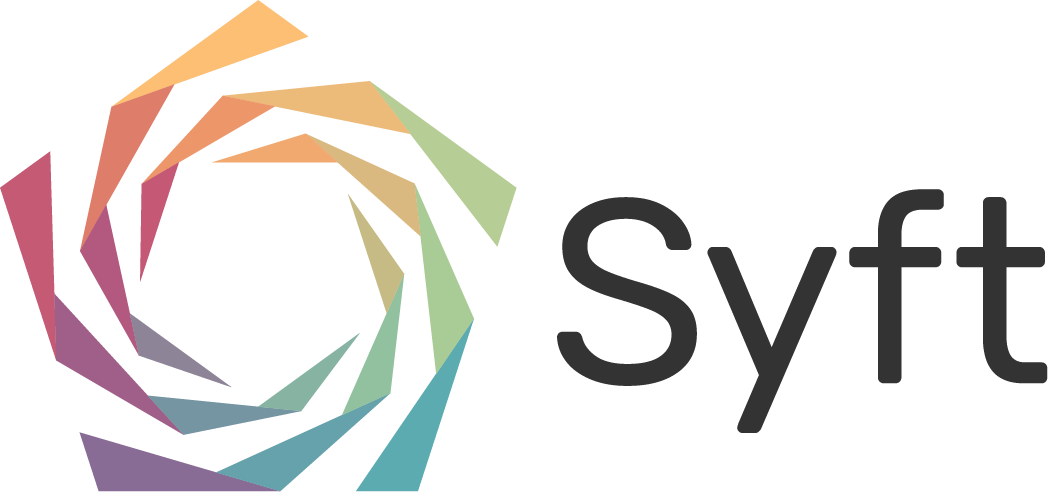

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 7f94259bfc8b33644b9e16b0329a569d

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


In [1]:
import tenseal as ts
import torch as th
import syft as sy

sy.load_lib("tenseal")

# run this if you are doing this locally
# duet = sy.join_duet(loopback=True)

# put the session id as parameter
duet = sy.join_duet("2d18b0afe778ac9ef381a3bd85f1c753")

After that, the data owner made the context and the encrypted vector available for us to fetch, we need to request permission to have them.

In [2]:
duet.store.pandas

ID     Tags Description
0  <UID: 72631a6ad9164e0f9a04b70f57fb5469>    [ctx]            
1  <UID: bf4a3dd48ee34f2a93945ab8fe202f52>  [enc_x]

In [3]:
context_ptr = duet.store["ctx"]
enc_x_ptr = duet.store["enc_x"]

In [4]:
# requestion get permissions: the data owner will need to accept them
context_ptr.request("I want to get the context")
enc_x_ptr.request("I want to get the encrypted instance")

After having the data owner accepting our requests, we can get the context and the encrypted instance.

In [5]:
context = context_ptr.get()
enc_x = enc_x_ptr.get()
# we need to link enc_x to the context: remember serialization
enc_x.link_context(context)

At this point, we should have a pre-trained model that we will use to evaluate the encrypted instance, but here, we will perform the training since we don't have any pre-trained model, then use that to evaluate the encrypted input.

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

train_X = th.load("data/train_X.pt")
train_y = th.load("data/train_y.pt")

# Training dataset
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=64)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 12)
        
    def forward(self, x):
        out = self.fc1(x)
        out = out * out
        out = self.fc2(out)
        return out
    

def train(model, device, train_loader, optimizer, criterion, epochs):
    losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        model.eval()
        print('Train Epoch: {:2d}   Avg Loss: {:.6f}'.format(epoch, th.mean(th.tensor(losses))))

    return model


model = Model()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = train(model, device, train_loader, optimizer, criterion, 30)

Train Epoch:  1   Avg Loss: 0.673643
Train Epoch:  2   Avg Loss: 0.609538
Train Epoch:  3   Avg Loss: 0.540524
Train Epoch:  4   Avg Loss: 0.492570
Train Epoch:  5   Avg Loss: 0.459035
Train Epoch:  6   Avg Loss: 0.434178
Train Epoch:  7   Avg Loss: 0.414760
Train Epoch:  8   Avg Loss: 0.398928
Train Epoch:  9   Avg Loss: 0.385562
Train Epoch: 10   Avg Loss: 0.373959
Train Epoch: 11   Avg Loss: 0.363659
Train Epoch: 12   Avg Loss: 0.354358
Train Epoch: 13   Avg Loss: 0.345855
Train Epoch: 14   Avg Loss: 0.338013
Train Epoch: 15   Avg Loss: 0.330733
Train Epoch: 16   Avg Loss: 0.323945
Train Epoch: 17   Avg Loss: 0.317590
Train Epoch: 18   Avg Loss: 0.311622
Train Epoch: 19   Avg Loss: 0.306001
Train Epoch: 20   Avg Loss: 0.300694
Train Epoch: 21   Avg Loss: 0.295673
Train Epoch: 22   Avg Loss: 0.290913
Train Epoch: 23   Avg Loss: 0.286392
Train Epoch: 24   Avg Loss: 0.282092
Train Epoch: 25   Avg Loss: 0.277994
Train Epoch: 26   Avg Loss: 0.274084
Train Epoch: 27   Avg Loss: 0.270348
T

Now time to have our PyTorch-like model that can process encrypted inputs

In [7]:
class HEModel:
    def __init__(self, fc1, fc2):
        self.fc1_weight = fc1.weight.t().tolist()
        self.fc1_bias = fc1.bias.tolist()
        self.fc2_weight = fc2.weight.t().tolist()
        self.fc2_bias = fc2.bias.tolist()
        
    def forward(self, encrypted_vec):
        # first fc layer + square activation function
        encrypted_vec = encrypted_vec.mm(self.fc1_weight) + self.fc1_bias
        encrypted_vec *= encrypted_vec
        # second fc layer
        encrypted_vec = encrypted_vec.mm(self.fc2_weight) + self.fc2_bias
        return encrypted_vec
    
    def __call__(self, x):
        return self.forward(x)

In [8]:
he_model = HEModel(model.fc1, model.fc2)
encrypted_result = he_model(enc_x)

Now we can send the encrypted result to the data owner

In [9]:
encrypted_result.send(duet, searchable=True, tags=["encrypted_result"])